In [1]:
# importing packages
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# for pretty printing
sm.init_printing(use_unicode=True)

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

### **Question 1** ###


**The task:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

We start by defining the value function in both periods, $v_2(h_2)$ and $v_1(h_1)$:

In [4]:
# A. defining v2

# i. defining the utility of consumption
def utility(c,rho):
    return c**(1-rho)/(1-rho)

# ii. defining the disutility of work
def disutility(gamma,l):
    return gamma*l

# iii. defining the value function for period 2
def v2(h2,w,b,rho,gamma,l2):
    if l2>0:
        c2 = w*h2*l2
    else:
        c2 = b
    return utility(c2,rho) - disutility(gamma,l2)

# B. defining v1
def v1(h1,w,b,rho,gamma,beta,Delta,v2_interp,l1):
    
    # i. Including the constraint for c1 in the function
    if l1>0:
        c1 = w*h1*l1
    else:
        c1 = b    
        
    # ii. v2 value, if low h2
    h2_low = h1 + l1 + 0
    v2_low = v2_interp([h2_low])[0]
    
    # iii. v2 value, if high h2
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # iv. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # v. total value
    return utility(c1, rho) - disutility(gamma, l1) + beta*v2

Solving the model in period 2 

In [6]:
# A. defining the solution  
def solve_period_2(rho, gamma, beta, Delta, w, b):
    
    # i. grids
    h2_vec = np.linspace(1e-8,1.5,100)
    l2_vec = np.empty(100)
    v2_vec0 = np.empty(100)
    v2_vec1 = np.empty(100)
    pli2 = np.empty(100)
    
    # ii. solve for each h2 value in grid
    for i,h2 in enumerate(h2_vec):

        # the agent will only work if utility from working is higher than utility from not working
        if v2(h2, w, b, rho, gamma, l2=1) > v2(h2, w, b, rho, gamma, l2=0): 
            v2_vec1[i] = v2(h2, w, b, rho, gamma, l2=1) # calculates and saves the value when working
            l2_vec[i] = 1 
        else:
            v2_vec1[i] = v2(h2, w, b, rho, gamma, l2=0) # calculates and saves the value when not working
            l2_vec[i] = 0
        v2_vec0[i] = v2(h2, w, b, rho, gamma, l2=0) # calculates the value for l = 0 and c = b
        pli2[i] = w*h2 # calculates potential labour income given l = 1
            
    return h2_vec,l2_vec,v2_vec1,v2_vec0,pli2

# B. solving the model
h2_vec,l2_vec,v2_vec1,v2_vec0,pli2 = solve_period_2(rho, gamma, beta, Delta, w, b)

Plotting the solution

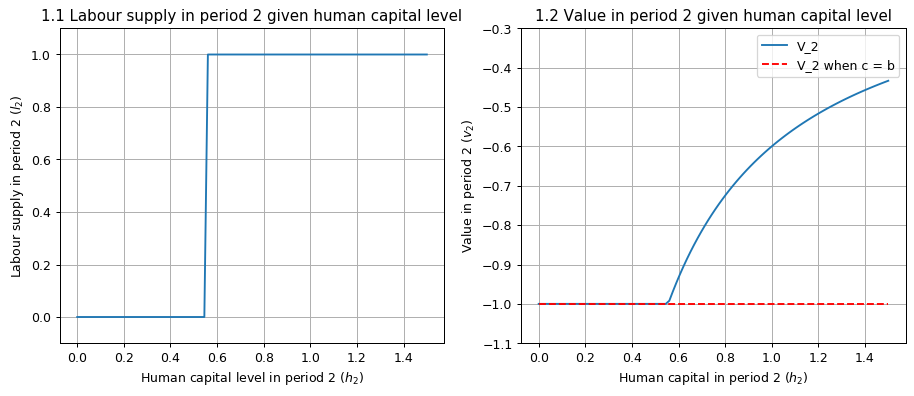

In [7]:
# A. plots labour supply as a function of human capital
fig = plt.figure(figsize=(8,4),dpi=90)
ax = fig.add_subplot(1,2,1)
ax.plot(h2_vec,l2_vec)
ax.grid()
ax.set_xlabel('Human capital level in period 2 ($h_2$)') # 
ax.set_ylabel('Labour supply in period 2 ($l_2$)')
ax.set_title('1.1 Labour supply in period 2 given human capital level')
ax.set_ylim([-0.1,1.1]);

# B. plots the value function given human capital
ax = fig.add_subplot(1,2,2)
ax.plot(h2_vec,v2_vec1, label = 'V_2')
ax.plot(h2_vec,v2_vec0, linestyle= 'dashed', color='red', label = 'V_2 when c = b')
ax.grid() 
ax.legend()
ax.set_xlabel('Human capital in period 2 ($h_2$)') # 
ax.set_ylabel('Value in period 2 ($v_2$)')
ax.set_title('1.2 Value in period 2 given human capital level')
ax.set_ylim([-1.1,-0.3]);

plt.subplots_adjust(top=1,right=1.3)

Before we interpret the two figures, we find the exact cutoff value for human capital.

In [14]:
# A. defining a function that finds the cutoff value for human capital

def cutoffval_h(rho,gamma,w,b):
    
    # i. function: squared difference between utility in period 2 of working and not working    
    obj = lambda h: (v2(h,w,b,rho,gamma,1)-v2(h,w,b,rho,gamma,0))**2
    x0 = 0 # initial guess
        
    # i. find the cutoff value by minimising the squared difference
    opt_cutoff = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[0,1.5]) 

    return opt_cutoff.x

# B. printing the result
print(f'The worker will choose to work if h > {cutoffval_h(rho,gamma,w,b):.4}\n ')

The worker will choose to work if h > 0.5556
 


Figure 1.1 shows that the value in period 2 when not working and when working is equal to eachother when $h_2=0.5556$, and an agent will only decide to work in period 2 if $h_2 \geq 0.5556$. Figure 1.2 shows that when $h_2>0.5556$ the value function is increasing in the human capital level, but at a decreasing rate.

### **Question 2** ###

**The task:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

We construct an interpolator to calculate $v_1(h_1)$

In [9]:
v2_interp = interpolate.RegularGridInterpolator((h2_vec,), v2_vec1, 
                                                bounds_error=False,fill_value=None)

Solving the model in period 1

In [10]:
# A. defining the solution
def solve_period_1(rho, gamma, beta, Delta, w, b, v2_interp):

    # i. grids
    h1_vec = np.linspace(1e-8,1.5,100)
    l1_vec = np.empty(100)
    v1_vec0 = np.empty(100)
    v1_vec1 = np.empty(100)
    pli1 = np.empty(100)
    
    # ii. solve for each h1 value in grid
    for i,h1 in enumerate(h1_vec):
        
        # the agent will only work if utility from working is higher than utility from not working
        if v1(h1, w, b, rho, gamma, beta, Delta, v2_interp, l1=1) > v1(h1, w, b, rho, gamma, beta, Delta, v2_interp, l1=0): 
            v1_vec1[i] = v1(h1, w, b, rho, gamma, beta, Delta, v2_interp, l1=1) # Calculates and saves the value when working
            l1_vec[i] = 1
        else:
            v1_vec1[i] = v1(h1, w, b, rho, gamma, beta, Delta, v2_interp, l1=0) # Calculates the value when not working
            l1_vec[i] = 0
        v1_vec0[i] = utility(c = b, rho = rho) + beta*utility(c = b, rho = rho) # Calculates the value for l = 0 and c = b
        pli1[i] = w*h1 # Calculates potential labour income given l = 1
        
    return h1_vec,l1_vec,v1_vec1,v1_vec0

# B. solving the model
h1_vec,l1_vec,v1_vec1,v1_vec0 = solve_period_1(rho, gamma, beta, Delta, w, b, v2_interp)

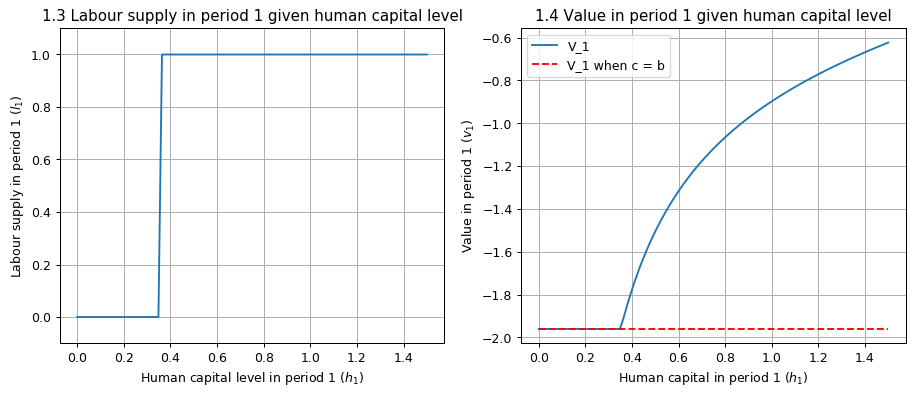

In [11]:
# A. plots labour supply as a function of human capital
fig = plt.figure(figsize=(8,4),dpi=90)
ax = fig.add_subplot(1,2,1)
ax.plot(h1_vec,l1_vec)
ax.grid()
ax.set_xlabel('Human capital level in period 1 ($h_1$)') # 
ax.set_ylabel('Labour supply in period 1 ($l_1$)')
ax.set_title('1.3 Labour supply in period 1 given human capital level')
ax.set_ylim([-0.1,1.1]);

# B. plots the value function given human capital
ax = fig.add_subplot(1,2,2)
ax.plot(h1_vec,v1_vec1, label = 'V_1')
ax.plot(h1_vec,v1_vec0, linestyle= 'dashed', color='red', label = 'V_1 when c = b')
ax.grid() 
ax.legend()
ax.set_xlabel('Human capital in period 1 ($h_1$)') # 
ax.set_ylabel('Value in period 1 ($v_1$)')
ax.set_title('1.4 Value in period 1 given human capital level')
plt.subplots_adjust(top=1,right=1.3)

Before we interpret the two figures, we find the exact cutoff value for human capital.

In [15]:
# A. defining a function that finds the cutoff value for human capital

def cutoffval_h(rho,gamma,w,b):
    
    # i. function: squared difference between utility in period 2 of working and not working    
    obj = lambda h: (v1(h,w,b,rho,gamma,beta,Delta,v2_interp,1)-v1(h,w,b,rho,gamma,beta,Delta,v2_interp,0))**2
    x0 = 0 # initial guess
     
    # ii. find the cutoff value by minimising the squared difference
    opt_cutoff = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[0,1.5]) 

    return opt_cutoff.x

# B. printing the result
print(f'The worker will choose to work if h > {cutoffval_h(rho,gamma,w,b):.4}\n ')

The worker will choose to work if h > 0.3518
 


Figure 1.3 shows that the value in period 1 when not working and when working is equal to eachother when $h_1=0.3518$, and an agent will only decide to work in period 1 if $h_1 \geq 0.3518$. Figure 1.4 shows that when $h_1>0.3518$ the value function is increasing in the human capital level, but at a decreasing rate.

### **Question 3** ###

**The task:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

The worker will never choose to work in period 2 if her/his potential wage income ($w h_2 l_2$) is below the unemployment benefit (b) since this is the last period in the model and no capital accumulation will take place after this period. In period 1 the worker can be willing to supply labour even if her potential wage income is lower than the unemployment benefits, because of the possible gains through human capital accumulation in period 2. This is the reason why the worker in this model is willing to start working at a human capital level of $0.352$ in period 1 even though that yields a potential wage income of $w h_1 l_1 = 2*0.352*1 = 0.7$ which is lower than the unemployment benefits, $b=1$. The human capital level at which the worker is willing to work is, therefore, also higher in period 2 than in period 1. 

This is illustrated in the two figures below, where we have plotted the potential labour income against labour supply in both period 1 and 2.

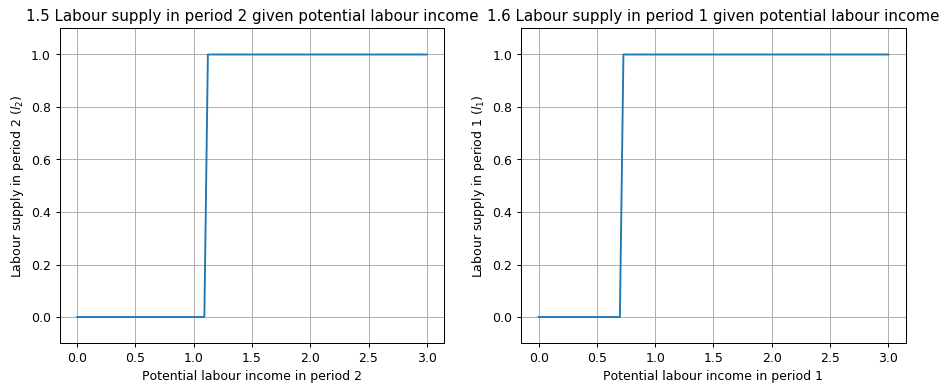

In [16]:
# A. plots labour supply as a function of potential labour income, period 2.
fig = plt.figure(figsize=(8,4),dpi=90)
ax = fig.add_subplot(1,2,1)
ax.plot(pli2,l2_vec)
ax.grid()
ax.set_xlabel('Potential labour income in period 2') # 
ax.set_ylabel('Labour supply in period 2 ($l_2$)')
ax.set_title('1.5 Labour supply in period 2 given potential labour income')
ax.set_ylim([-0.1,1.1]);

# B. plots labour supply as a function of potential labour income, period 1.
ax = fig.add_subplot(1,2,2)
ax.plot(pli2,l1_vec)
ax.grid()
ax.set_xlabel('Potential labour income in period 1') # 
ax.set_ylabel('Labour supply in period 1 ($l_1$)')
ax.set_title('1.6 Labour supply in period 1 given potential labour income')
ax.set_ylim([-0.1,1.1]);

plt.subplots_adjust(top=1,right=1.3)

Figure 1.5 shows that the worker only works in period 2 if her/his potential wage income is equal or above $w h_2 l_2 = 2*0.556*1=1.11$, which is larger than the unemployment benefit of $b=1$. However, in period 1 the worker is willing to supply labour when her/his potential wage income is equal or above $w h_1 l_1 = 2*0.352*1 = 0.7$, which is smaller than the unemployment benefit of $b=1$.

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [17]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

In this problem we use the funcion `root_scalar`, if it is not availible then run `conda update scipy` in your terminal. 

### **Question 1** ###

**The task**: Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

We start by defining the relevant variables and the two functions.

In [18]:
# A. defining the relevant symbols
h = sm.symbols('h')
alpha = sm.symbols('alpha')
v = sm.symbols('v_t')
b = sm.symbols('b')
pi1 = sm.symbols('pi_t') 
pi0 = sm.symbols('pi_t-1')
gamma = sm.symbols('gamma')
y1 = sm.symbols('y_t')
y0 = sm.symbols('y_t-1')
phi = sm.symbols('phi')
s1 = sm.symbols('s_t')
s0 = sm.symbols('s_t-1')

# B. defining the AD-curve
AD = sm.Eq((1/(h*alpha))*(v-(1+b*alpha)*y1))

# C. defining the SRAS-curve
SRAS = sm.Eq(pi0+gamma*y1-phi*gamma*y0+s1-phi*s0)

We set the AD function equal to the SRAS function.

In [19]:
AD_SRAS = sm.Eq((1/(h*alpha))*(v-(1+b*alpha)*y1), (pi0+gamma*y1-phi*gamma*y0+s1-phi*s0))

We solve for $y_t$ by isolating $y_t$

The equilibrium value of y is: 


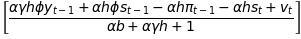

In [20]:
# A. solving for y_t
yt_star = sm.solve(AD_SRAS, y1)

# B. printing the result
print(f'The equilibrium value of y is: ')
yt_star

We solve for $\pi_t$ by inserting $y^*$ in the AD function

The equilibrium value of pi is: 


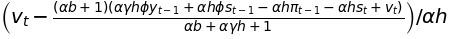

In [21]:
# A. solving for pi_t
pi_star = (1/(h*alpha))*(v-(1+b*alpha)*yt_star[0])

# B. printing the result
print(f'The equilibrium value of pi is: ')
pi_star

### **Question 2** ###

**The task:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

We define a list of variables where $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$ as well as $v_t = 0.1$.

In [22]:
var = {}

var['y0'] = 0
var['pi0'] = 0
var['s0'] = 0
var['s1'] = 0
var['v'] = 0
var['v_new'] = 0.1

We find the equilibrium values $y^*$ and $pi^*$.

In [23]:
# A. finding y

# i. turning the yt_star equation into a python equation
find_yt_star = sm.lambdify((v, s1, pi0, s0, y0, alpha, h, b, phi, gamma),yt_star[0])

# ii. inserting the values
print_yt_star= find_yt_star(var['v'], var['s1'], var['pi0'], var['s0'], var['y0'], alpha=par['alpha'], 
                            h=par['h'], b=par['b'], phi=par['phi'], gamma=par['gamma'])

# iii. printing the equilibrium value of y
print(f'The equilibrium value of y is {print_yt_star}')

# B. finding pi

# i. turning the pt_star equation into a python equation
find_pi_star = sm.lambdify((v, s1, pi0, s0, y0, alpha, h, b, phi, gamma),pi_star)

# ii. inserting the values
print_pi_star= find_pi_star(var['v'], var['s1'], var['pi0'], var['s0'], var['y0'], alpha=par['alpha'], 
                            h=par['h'], b=par['b'], phi=par['phi'], gamma=par['gamma'])

# iii. printing the equilibrium value of pi
print(f'The equilibrium value of pi is {print_pi_star}')

The equilibrium value of y is 0.0
The equilibrium value of pi is 0.0


Next we find the equilibrium values $y^*$ and $pi^*$, when there is a demand shock ($v_t=0.1$).

In [24]:
# A. finding y with a demand shock

# i. inserting the values
print_yt_star= find_yt_star(var['v_new'], var['s1'], var['pi0'], var['s0'], var['y0'], alpha=par['alpha'], 
                            h=par['h'], b=par['b'], phi=par['phi'], gamma=par['gamma'])

# ii. printing the result
print(f'The equilibrium value of y with a demand shock is {print_yt_star}')

# B. finding pi with a demand shock

# i. inserting the values
print_pi_star= find_pi_star(var['v_new'], var['s1'], var['pi0'], var['s0'], var['y0'], alpha=par['alpha'], 
                            h=par['h'], b=par['b'], phi=par['phi'], gamma=par['gamma'])

# ii. printing the result
print(f'The equilibrium value of pi with a demand shock is {print_pi_star}')

The equilibrium value of y with a demand shock is 0.0244140625
The equilibrium value of pi with a demand shock is 0.001831054687500002


In the first case all parameters are set to be equal to zero and the equilibrium values are $y^* = 0$ and $\pi^* = 0$. In the case with a demand shock ($v_t = 0.1$), the equilibrium values are $y^* = 0.0244$ and $\pi^* = 0.0018$. Hence, a positive demand shock increases both output and inflation. Looking at the equation for output, $y_t^*$, and inflation, $\pi_t^*$, found in question 1 this was to be expected since both $y_t^*$ and $\pi_t^*$ is positively dependent of demand shocks in period $t$.

In order to illustrate the two equilibria we start by defining the AD function and the SRAS function.

In [25]:
# A. defining the AD function
def AD(y1,h,b,alpha,v):
    return (1/(h*alpha))*(v-(1+b*alpha)*y1)

# B. defining the SRAS function
def SRAS(pi0,gamma,y1,phi,y0,s1,s0):
    return pi0+gamma*y1-phi*gamma*y0+s1-phi*s0

In order to plot the two AD functions and the SRAS function, we have to insert the given parameter values. As we do not have any values for y, we draw some random  numbers with the `linspace` function. 

In [26]:
# A. drawing y-values
y_values = np.linspace(-0.2,0.2,200) # the interval is chosen as all the equilibrium values are close to zero

# B. insert parameter values into the functions
AD_curve = AD(y1=y_values,h=par['h'],b=par['b'],alpha=par['alpha'], v=var['v'])

AD_curve_shock = AD(y1=y_values,h=par['h'],b=par['b'],alpha=par['alpha'], v=var['v_new'])

SRAS_curve = SRAS(pi0=var['pi0'], gamma=par['gamma'], y1=y_values, phi=par['phi'],
                     y0=var['y0'], s1=var['s1'], s0=var['s0'])

Now we plot the the two AD curves and the SRAS curve to illustrate how the equilibrium changes when instead $v_t = 0.1$.

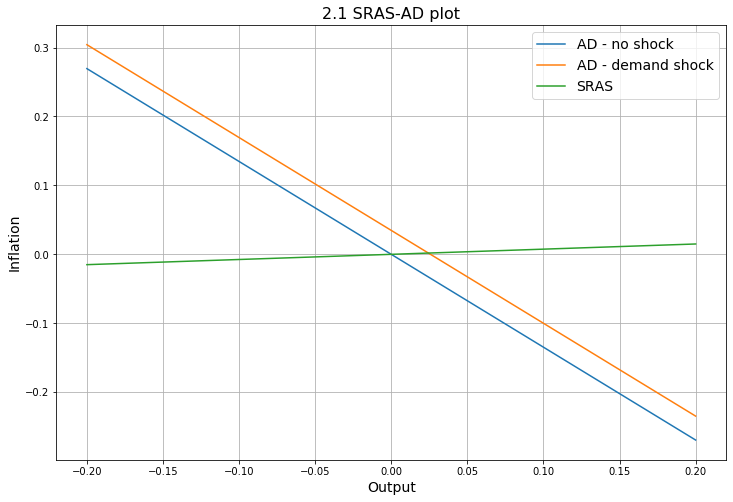

In [27]:
# Plots two AD curves and the SRAS curve
plt.figure(figsize=(12,8))
plt.plot(y_values,AD_curve)
plt.plot(y_values,AD_curve_shock)
plt.plot(y_values,SRAS_curve)
plt.grid()
plt.xlabel('Output', fontsize=14)  
plt.ylabel('Inflation', fontsize=14)
plt.title('2.1 SRAS-AD plot', fontsize=16)
plt.legend(('AD - no shock', 'AD - demand shock', 'SRAS'), loc='best',prop={'size':14})
plt.show()

When the economy is hit by a demand shock ($v_t = 0.1$) the AD-curve shifts upwards while the SRAS-curve remains unaffected. Hence, both the inflation and output increases. 

### **Question 3** ###

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [28]:
par['delta'] = 0.80
par['omega'] = 0.15

**The task:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

First, we define the two new shocks.

In [29]:
# A. defining new demand shock
def v_shock(v_ny,x):
    return par['delta']*v_ny+x

# B. defining new supply shock
def s_shock(s_ny,c):
    return par['omega']*s_ny+c

Defining vectors and number of time periods. 

In [30]:
# A. defining periods
T = 100

# B. defining vectors
y_vec = [0]
pi_vec = [0]
v_vec = [0]
s_vec = [0]
c_vec = np.zeros(T)
x_vec = np.zeros(T)
x_vec[1] = 0.1 # since x0=0.1

We now simultate the AS-AD model.

In [31]:
# C. simulating the AS-AD model
for t in range(1,T):
    
    v_vec.append(v_shock(v_vec[t-1], x_vec[t]))
    s_vec.append(s_shock(s_vec[t-1], c_vec[t]))
    y_vec.append(find_yt_star(v_vec[t],s_vec[t],pi_vec[t-1],s_vec[t-1],y_vec[t-1],par['alpha'],par['h'],par['b'],
                              par['phi'],par['gamma']))
    pi_vec.append(find_pi_star(v_vec[t], s_vec[t], pi_vec[t-1], s_vec[t-1], y_vec[t-1],par['alpha'], par['h'],
                               par['b'],par['phi'],par['gamma']))

The final step is to plot the figures.

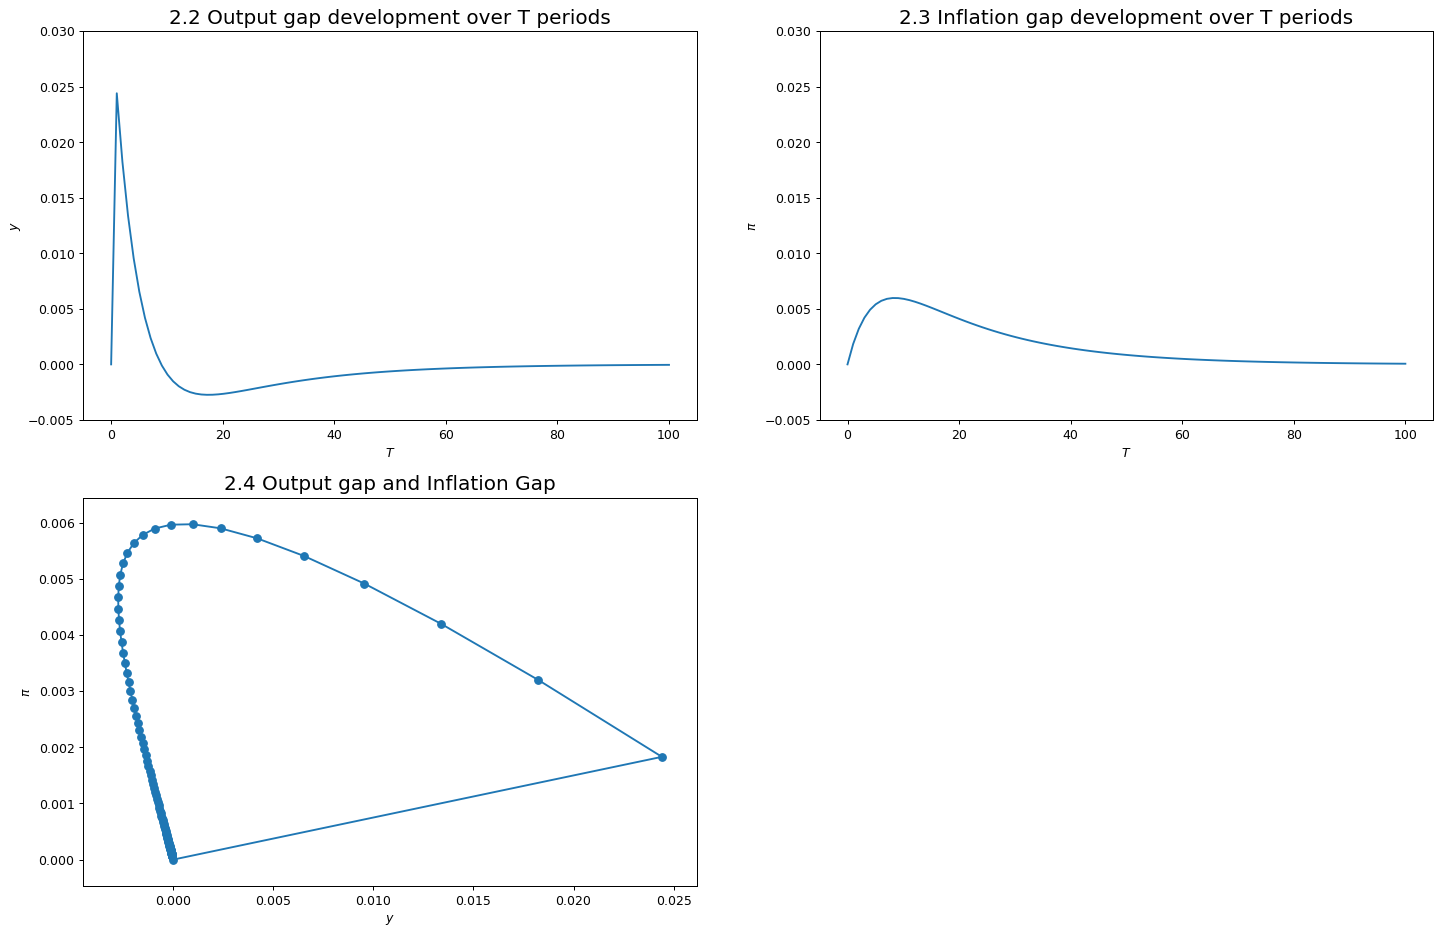

In [32]:
# D. creating the figures
periods = np.linspace(0,T,T)
fig = plt.figure(figsize=(8,4),dpi=90)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

# i. figure 2.2
ax1.plot(periods,y_vec)
ax1.set_title('2.2 Output gap development over T periods', fontsize=16)
ax1.set_xlabel('$T$')
ax1.set_ylabel('$y$')
ax1.set_ylim(-0.005,0.03)

# ii. figure 2.3
ax2.plot(periods,pi_vec)
ax2.set_title('2.3 Inflation gap development over T periods', fontsize=16)
ax2.set_xlabel('$T$')
ax2.set_ylabel('$\pi$')
ax2.set_ylim(-0.005,0.03)

# iii. figure 2.4
ax3.plot(y_vec,pi_vec)
ax3.scatter(y_vec,pi_vec)
ax3.set_title('2.4 Output gap and Inflation Gap', fontsize=16)
ax3.set_xlabel('$y$')
ax3.set_ylabel('$\pi$')

plt.subplots_adjust(top=2.5,right=2)

Figure 2.2 and figure 2.3 show the effects of a demand shock on the output gap and inflation gap over the T periods. In the period just after the shock, the effect on $y$ is four times larger than the effect on $\pi$. After the positive effect for output, $y$ drops to negative values for a short period. Thereafter, it converges back to the long run equilibrium. The effect for $\pi$ is generally not that large as $y$ and after the peak, the value converges back to the long run equilibrium.           
Figure 2.4 shows the combination of short run equilibria for $y$ and $\pi$. We see that the effect is largest for $y$ in the fist period. For $\pi$ the effect is largest later, around 8-9 periods after the shock.  

### **Question 4** ####

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [33]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**The task:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

We are now given new information about the demand shock, $x_t$, and the supply shock, $c_t$. In order to simulate the AS-AD model we start by defining a new set of vectors and draw the demand and supply shock from a normal distribution.

In [34]:
# A. setting a seed number
seed = 2000
np.random.seed(seed)

# B. defining the number of periods
T = 1000

# C. defining a new set of vectors
y_vec2 = [0]
pi_vec2 = [0]
v_vec2 = [0]
s_vec2 = [0]

# D. drawing the demand and supply shock from a normal distribution
x_vec2 = np.random.normal(loc=0,scale=par['sigma_x'],size=T)
c_vec2 = np.random.normal(loc=0,scale=par['sigma_c'],size=T)

We now simulate the AS-AD model

In [35]:
# E. simulating the AS-AD model
for t in range(1,T):    
    v_vec2.append(v_shock(v_vec2[t-1], x_vec2[t]))
    s_vec2.append(s_shock(s_vec2[t-1], c_vec2[t]))
    y_vec2.append(find_yt_star(v_vec2[t],s_vec2[t],pi_vec2[t-1],s_vec2[t-1],y_vec2[t-1],par['alpha'],par['h'],
                               par['b'],par['phi'],par['gamma']))
    pi_vec2.append(find_pi_star(v_vec2[t], s_vec2[t], pi_vec2[t-1], s_vec2[t-1], y_vec2[t-1],par['alpha'], par['h'],
                                par['b'],par['phi'],par['gamma']))

The final step is to plot the figures.

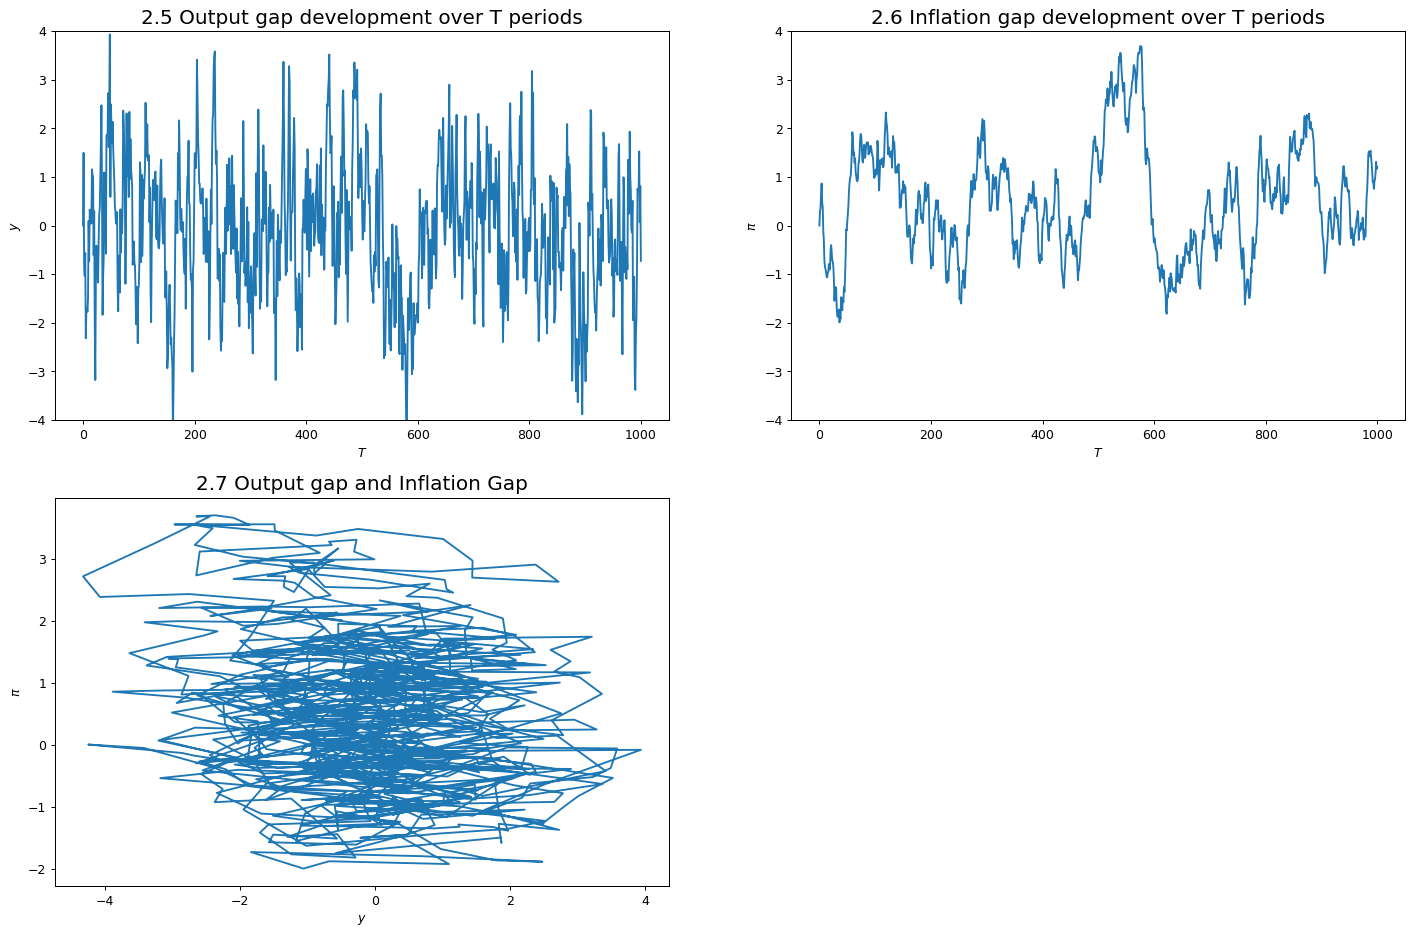

In [36]:
# F. creating a figure
periods2 = np.linspace(0,T,T)
fig = plt.figure(figsize=(8,4),dpi=90)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

# i. figure 2.5
ax1.plot(periods2,y_vec2)
ax1.set_title('2.5 Output gap development over T periods', fontsize=16)
ax1.set_xlabel('$T$')
ax1.set_ylabel('$y$')
ax1.set_ylim(-4,4)

# ii. figure 2.6
ax2.plot(periods2,pi_vec2)
ax2.set_title('2.6 Inflation gap development over T periods', fontsize=16)
ax2.set_xlabel('$T$')
ax2.set_ylabel('$\pi$')
ax2.set_ylim(-4,4)

# iii. figure 2.7
ax3.plot(y_vec2,pi_vec2)
ax3.set_title('2.7 Output gap and Inflation Gap', fontsize=16)
ax3.set_xlabel('$y$')
ax3.set_ylabel('$\pi$')

plt.subplots_adjust(top=2.5,right=2)

The three figures show the same as in question 3, but now the shocks are stochastic instead of persistent disturbances. This means that the economy is constantly hit by demand shocks and supply shocks. The model in question 3 was only hit one time and both $y$ and $\pi$ converged back to the long run equilibrium. With stochastic shocks $y$ and $\pi$ do not converge back to the long run equilibrium. Compared to before, the gaps are also mean reverting. 

We now calculate the five statistics.

In [37]:
# A. calculating the five statistics

# i. calculating the variance of y_t
print(f'The variance of y_t is: var(y_t) = {np.var(y_vec2):.4f}')

# ii. calculating the variance of pi_t
print(f'The variance of pi_t is: var(pi_t) = {np.var(pi_vec2):.4f}')

# iii. calculating the correlation between y_t and pi_t
ypi_corr = np.corrcoef(y_vec2,pi_vec2)
print(f'The correlation between y_t and pi_t is: corr(y_t,pi_t) = {ypi_corr[0,1]:.4f}')

# iv. calculating the auto-correlation between y_t and y_(t-1)
y_auto = np.corrcoef(y_vec2[1:],y_vec2[:-1])
print(f'The autocorrelation between y_t and y_t-1 is: corr(y_t,y_t-1) = {y_auto[0,1]:.4f}')

# v. calculating the auto-correlation between pi_t and pi_(t-1)
pi_auto = np.corrcoef(pi_vec2[1:],pi_vec2[:-1])
print(f'The autocorrelation between pi_t and pi_t-1 is: corr(pi_t,pi_t-1) = {pi_auto[0,1]:.4f}') 

The variance of y_t is: var(y_t) = 1.8851
The variance of pi_t is: var(pi_t) = 1.2624
The correlation between y_t and pi_t is: corr(y_t,pi_t) = -0.1929
The autocorrelation between y_t and y_t-1 is: corr(y_t,y_t-1) = 0.7607
The autocorrelation between pi_t and pi_t-1 is: corr(pi_t,pi_t-1) = 0.9827


There is a negative correlation between $y_t$ and $\pi_t$. Normally, we would expect the opposite. Further, the autocorrelations for  both $y_t$ and $\pi_t$ are positive. This is an indication of persistence meaning the tendency of a system to remain in the same state from one observation to the next.  

### **Question 5** ###

**The task:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

The value of phi that makes corr(y,pi) = 0.31 is phi = 0.991
Test of the correlation 0.3100


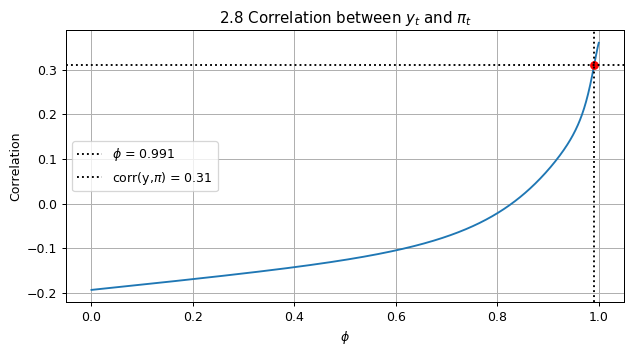

In [38]:
# A. simulation of AS-AD Model with changes in phi

# i. setting seed a seed number
seed = 2000
np.random.seed(seed)

# ii. number of periods (the same number as in question 4)
T = 1000

# iii. drawing a new set of demand and supply from normal distributions
x_vec3 = np.random.normal(loc=0,scale=par['sigma_x'],size=T)
c_vec3 = np.random.normal(loc=0,scale=par['sigma_c'],size=T)

# iv. defining a simulation function
def simulation_phi(phi):
    y_vec3 = [0]
    pi_vec3 = [0]
    v_vec3 = [0]
    s_vec3 = [0]
    ypi_corr2 = [0]
    for t in range(1,T):
        
        v_vec3.append(v_shock(v_vec3[t-1], x_vec3[t]))
        s_vec3.append(s_shock(s_vec3[t-1], c_vec3[t]))
        y_vec3.append(find_yt_star(v_vec3[t],s_vec3[t],pi_vec3[t-1],s_vec3[t-1],y_vec3[t-1],par['alpha'],par['h'],
                                   par['b'],phi,par['gamma']))
        pi_vec3.append(find_pi_star(v_vec3[t],s_vec3[t],pi_vec3[t-1],s_vec3[t-1],y_vec3[t-1],par['alpha'],par['h'],
                                    par['b'],phi,par['gamma']))
    
    ypi_corr2 = np.corrcoef(y_vec3, pi_vec3)[1,0]
    
    return y_vec3, pi_vec3, ypi_corr2

# iv. simulating the correlation between y and pi
phi_plot = np.linspace(1e-8,1,T)
corr_plot = []

for x in phi_plot:
    y_vec3, pi_vec3, ypi_corr2 = simulation_phi(x)
    corr_plot.append(ypi_corr2)

# v. fining the solution numerically 
obj_func = lambda phi: np.corrcoef(simulation_phi(phi)[0], simulation_phi( phi)[1])[1,0] - 0.31
result = optimize.root_scalar(obj_func, x0 = 0, bracket = [0,1], method = 'brentq')
phi_val = result.root
print(f'The value of phi that makes corr(y,pi) = 0.31 is phi = {phi_val:.3f}')
print(f'Test of the correlation {np.corrcoef(simulation_phi(phi_val)[0], simulation_phi(phi_val)[1])[1,0]:.4f}')

# vi. plotting the solution
plt.figure(figsize=(8,4),dpi=90)
plt.plot(phi_plot,corr_plot)
plt.plot(phi_val,0.31, marker='o', color="red")
plt.axvline(phi_val, linestyle='dotted', color="black", label=f'$\phi$ = {phi_val:.3f}')
plt.axhline(0.31, linestyle='dotted', color="black", label='corr(y,$\pi$) = 0.31')
plt.xlabel('$\phi$')
plt.ylabel('Correlation')
plt.title('2.8 Correlation between $y_t$ and $\pi_t$')
plt.grid()
plt.legend()
plt.show()

Figure 2.8 shows the correlation between $y_t$ and $\pi_t$ as a function of $\phi$. The correlation increases as $\phi$ increases. When $\phi = 0.99$ the correlation between $y_t$ and $\pi_t$ equals $0.31$.

### **Question 6** ###

**The task:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

We start by defining a vector of parameters.

In [39]:
pars = [par['sigma_x'],par['sigma_c'],par['phi']]

We define a function that returns the equilibrium values of $y_t$ and $\pi_t$ for different values of $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ and a function that calculates the five statistics stated above.

In [40]:
# A. defines a function that returns the vectors of the equilibrium y and pi
def equilibrium(T, pars):
    y_vec4 = [0]
    pi_vec4 = [0]
    v_vec4 = [0]
    s_vec4 = [0]
    x_vec4 = np.random.normal(loc=0,scale=pars[0],size=T) #sigma_x = pars[0]
    c_vec4 = np.random.normal(loc=0,scale=pars[1],size=T) #sigma_c = pars[1]
    
    for t in range(1,T):
        
        v_vec4.append(v_shock(v_vec4[t-1], x_vec4[t]))
        s_vec4.append(s_shock(s_vec4[t-1], c_vec4[t]))
        y_vec4.append(find_yt_star(v_vec4[t],s_vec4[t],pi_vec4[t-1],s_vec4[t-1],y_vec4[t-1],par['alpha'],par['h'],
                                   par['b'],pars[2],par['gamma'])) #phi = pars[2]
        pi_vec4.append(find_pi_star(v_vec4[t],s_vec4[t],pi_vec4[t-1],s_vec4[t-1],y_vec4[t-1],par['alpha'],par['h'],
                                    par['b'],pars[2],par['gamma'])) #phi = pars[2]
    
    return y_vec4, pi_vec4

# B. defines a function that return statistics
def stats(T, pars):
    y_vec4, pi_vec4 = equilibrium(T, pars)
    
    var_y = np.var(y_vec4)
    var_pi = np.var(pi_vec4)
    corr_ypi = np.corrcoef(y_vec4,pi_vec4)[0,1]
    acorr_y = np.corrcoef(y_vec4[:-1],y_vec4[1:])[0,1]
    acorr_pi = np.corrcoef(pi_vec4[:-1],pi_vec4[1:])[0,1]
    
    return var_y, var_pi, corr_ypi, acorr_y, acorr_pi

We now define a function that finds values of $\sigma_x$, $\sigma_c$ and $\phi$ that minimises the difference between the moments of this model and the moments of the US economy.

In [44]:
# A. function that finds values of sigma_x, sigma_c and phi
def find_pars(T):
    
    # i. function that minimises the difference
    def _min_moments(T,pars): 
        seed = 2000
        np.random.seed(seed)
        
        var_y, var_pi, corr_ypi, acorr_y, acorr_pi = stats(T, pars)

        test = np.zeros(5)
        
        test[0] += (var_y-1.64)**2
        test[1] += (var_pi-0.21)**2
        test[2] += (corr_ypi-0.31)**2
        test[3] += (acorr_y-0.84)**2
        test[4] += (acorr_pi-0.48)**2
        
        return  np.sum(test)
    
    min_moments= lambda x: _min_moments(T,x)
    
    # ii. setting inital guess and bounds (remember phi has to be between 0 and 1)
    x0 = [par['sigma_x'], par['sigma_c'],phi_val] #for phi we start with the value found in question 5
    bounds = ((0.0001,10000000), (0.0001,10000000),(0,1))
    
    # iii. call optimiser
    result = optimize.minimize(min_moments,x0,
                           method='SLSQP',
                           bounds=bounds    
                           )
    return result

# B. print results
result = find_pars(T)
var_y, var_pi, corr_ypi, acorr_y, acorr_pi = stats(T, result.x)
print(f'{result.message}\n')

Optimization terminated successfully.



The moments of this model and the US economy are:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

In [47]:
# prints the moments of this model for comparison
text = f'The moments of this model is: \n'
text += f'var(y_t):           {var_y:.2f}  \n'
text += f'var(pi_t):          {var_pi:.2f} \n'
text += f'corr(y_t,pi_t):     {corr_ypi:.2f} \n'
text += f'corr(y_t,y_t-1):    {acorr_y:.2f} \n'
text += f'corr(pi_t,pi_t-1):  {acorr_pi:.2f}\n'

print(text)

The moments of this model is: 
var(y_t):           1.81  
var(pi_t):          0.04 
corr(y_t,pi_t):     0.43 
corr(y_t,y_t-1):    0.81 
corr(pi_t,pi_t-1):  0.41



The results show that the $var(y_t)$, $corr(y_t,y_{t-1})$ and $corr(\pi_t,\pi_{t-1})$ are close to the ones in the US economy. The correlation between $y_t$ and $\pi_t$ is also fairly close in this model and the US economy. However, the variance of $\pi_t$ is substantially lower in our model compared to the US economy.
The values for $\sigma_x$, $\sigma_c$ and $\phi$ that produced the above results are the following:

In [48]:
text = f'The optimal values of the parameters are:\n'
text += f'sigma_x = {result.x[0]:.3f}\n'
text += f'sigma_c = {result.x[1]:.3f}\n'
text += f'phi     = {result.x[2]:.3f}\n \n'
print(text)

The optimal values of the parameters are:
sigma_x = 3.184
sigma_c = 0.165
phi     = 0.980
 



# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [49]:
# A. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# B. random draws
seed = 1986
np.random.seed(seed)

# C. preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# D. endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

### **Question 1** ###

**The task:** Plot the histograms of the budget shares for each good across agents.

First, we subtract the budget shares, $\beta$, from the given matrix, and then plot the histograms of each budget share for each good across agents.

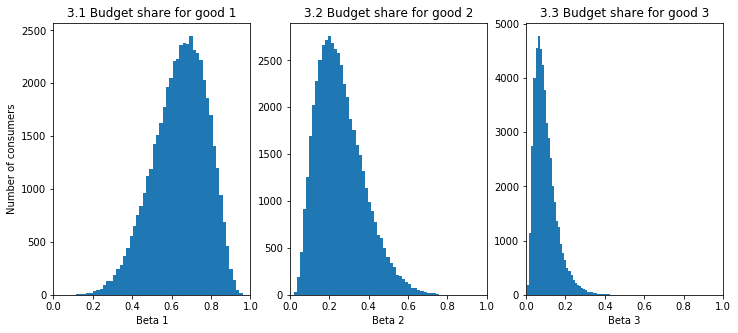

In [50]:
# A. substracting beta_1s, beta_2s and beta_3s from the given beta matrix
beta_1s = betas[:,0]
beta_2s = betas[:,1]
beta_3s = betas[:,2]

# B. initiating subplot
fig1, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,5))

# C. plotting histograms for each beta; setting titles, labels and limits for each plot

# i. specifying the left histogram
ax1.hist(beta_1s, bins=50)
ax1.set_title('3.1 Budget share for good 1')
ax1.set_xlabel('Beta 1')
ax1.set_ylabel('Number of consumers')
ax1.set_xlim(0,1)

# ii. specifying the middle histogram
ax2.hist(beta_2s, bins=50)
ax2.set_title('3.2 Budget share for good 2')
ax2.set_xlabel('Beta 2')
ax2.set_xlim(0,1)

# iii. specifying the right histogram
ax3.hist(beta_3s, bins=50)
ax3.set_title('3.3 Budget share for good 3')
ax3.set_xlabel('Beta 3')
ax3.set_xlim(0,1);

The three histograms show that most consumers wish to spend a large part - around 70 pct. - on good 1, around 20 pct. on good 2 and only 10 pct. on good 3. 

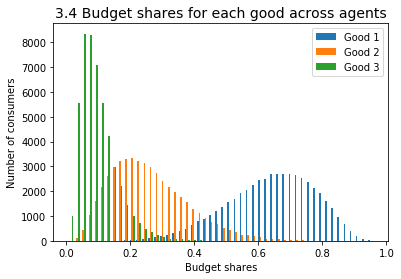

In [51]:
# plotting histograms in one figure for better comparison
plt.hist(betas, bins = 50, label = ['Good 1', 'Good 2', 'Good 3'])
plt.title('3.4 Budget shares for each good across agents', fontsize=14)
plt.xlabel('Budget shares')
plt.ylabel('Number of consumers')
plt.legend()

In figure 3.4 it becomes more clear that for good 3 the number of consumers is highly concentrated around a relatively low budget share, and hence the variation in the budget share across the N consumers is very low. For the two other goods, there is a larger variation, although there is a clear peak on both distributions at the above-mentioned values. 

### **Question 2** ###

**The task:** Plot the excess demand functions.

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

We start by defining the demand function for each good and thereafter the excess demand functions (demand - supply). 

In [52]:
# A. defining demand functions

# i. demand function for good 1
def demand_good1(p1,p2,e1,e2,e3,betas):
    I = e1*p1+e2*p2+e3
    return betas[:,0]*I/p1

# ii. demand function for good 2
def demand_good2(p1,p2,e1,e2,e3,betas):
    I = e1*p1+e2*p2+e3
    return betas[:,1]*I/p2

# iii. demand function for good 3
def demand_good3(p1,p2,e1,e2,e3,betas):
    I = e1*p1+e2*p2+e3
    return betas[:,2]*I # we have removed p3 here as it is numeraire

In [53]:
# B. defining excess demand functions

# i. excess demand function for good 1
def excess_good1(p1,p2,e1,e2,e3,betas):
    
    # o. summing demand
    demand = np.sum(demand_good1(p1,p2,e1,e2,e3,betas))
    
    # oo. summing supply, i.e. the endowments
    supply = np.sum(e1)
    
    # ooo. finding excess demand
    excess = demand-supply
    
    return excess

# ii. excess demand function for good 2
def excess_good2(p1,p2,e1,e2,e3,betas):
    
    # o. summing demand
    demand = np.sum(demand_good2(p1,p2,e1,e2,e3,betas))
    
    # oo. summing supply, i.e. the endowments
    supply = np.sum(e2)
    
    # ooo. finding excess demand
    excess = demand-supply
    
    return excess

# iii. excess demand function for good 3
def excess_good3(p1,p2,e1,e2,e3,betas):
    
    # o. summing demand
    demand = np.sum(demand_good3(p1,p2,e1,e2,e3,betas))
    
    # oo. summing supply, i.e. the endowments
    supply = np.sum(e3)
    
    # ooo. finding excess demand
    excess = demand-supply
    
    return excess

In order to plot the excess demand functions, we have to define a price vector for each of the prices, $p_1$ and $p_2$, to calculate the excess demand functions for a given set of price combinations. Note, $p_3$ is numeraire. 

In [54]:
# A. the number of price values
size = 200

# B. the price vectors
p1_s = np.linspace(0.1,10,size)
p2_s = np.linspace(0.1,10,size)

# C. transforming price vectors to grids
p1_grid, p2_grid = np.meshgrid(p1_s, p2_s) 

# D. create empty grids for excess demand
excess_1_grid = np.empty((size,size))
excess_2_grid = np.empty((size,size))
excess_3_grid = np.empty((size,size))

# E. calculate excess demand for each price combination
for i,p1 in enumerate(p1_s):
    for j,p2 in enumerate(p2_s):
        excess_1_grid[i,j] = excess_good1(p1,p2,e1,e2,e3,betas)
        excess_2_grid[i,j] = excess_good2(p1,p2,e1,e2,e3,betas)
        excess_3_grid[i,j] = excess_good3(p1,p2,e1,e2,e3,betas)

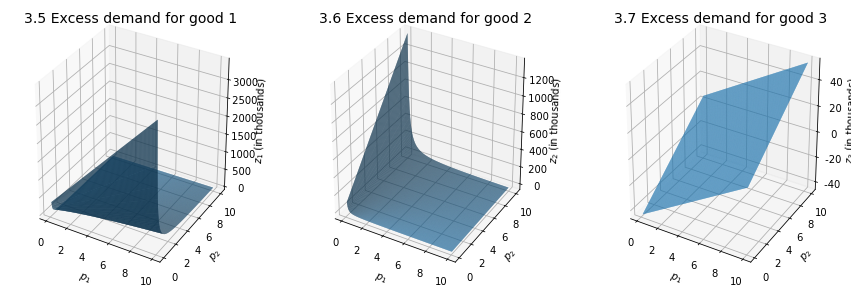

In [55]:
# A. plotting excess demand

# i. inititiating plot
fig = plt.figure(figsize=(15,5))

# ii. function to convert an axis into thousands
def thousands(x, pos):
    return ' %1.0f' % (x*1e-3)

# iii. calling a formatter
formatter = FuncFormatter(thousands)

# B. subplot for excess demand of good 1
axis1 = fig.add_subplot(1,3,1, projection = '3d')
fig1 = axis1.plot_surface(p1_grid, p2_grid, excess_1_grid, cstride=1, rstride=1)

# i. subplot specifications; title, labels etc. 
axis1.invert_yaxis()
axis1.set_title('3.5 Excess demand for good 1', fontsize=14)
axis1.set_xlabel('$p_1$')
axis1.set_ylabel('$p_2$')
axis1.set_zlabel('$z_1$ (in thousands)')
axis1.zaxis.set_major_formatter(formatter)

# C. subplot for excess demand of good 2
axis2 = fig.add_subplot(1,3,2, projection = '3d')
fig2 = axis2.plot_surface(p1_grid, p2_grid, excess_2_grid, cstride=1, rstride=1)

# i. subplot specifications; title, labels etc. 
axis2.invert_yaxis()
axis2.set_title('3.6 Excess demand for good 2', fontsize=14)
axis2.set_xlabel('$p_1$')
axis2.set_ylabel('$p_2$')
axis2.set_zlabel('$z_2$ (in thousands)')
axis2.zaxis.set_major_formatter(formatter)

# D. subplot for excess demand of good 3
axis3 = fig.add_subplot(1,3,3, projection = '3d')
fig3 = axis3.plot_surface(p1_grid, p2_grid, excess_3_grid, cstride=1, rstride=1)

# i. subplot specifications; title, labels etc. 
axis3.invert_yaxis()
axis3.set_title('3.7 Excess demand for good 3', fontsize=14)
axis3.set_xlabel('$p_1$')
axis3.set_ylabel('$p_2$')
axis3.set_zlabel('$z_3$ (in thousands)')
axis3.zaxis.set_major_formatter(formatter)

For good 1 we see that the excess demand, $Z_1$, is increasing as the price, $p_1$, increases. This makes intuitive sense because when $p_1$ increases a decreasing amount of consumers can buy the good. This will lead to an increase in the excess demand, $Z_1$. When the price on good 2, $p_2$, is low then the income $I$ will be low as well since income is a function of the prices. Hence, when $p_2$ is increasing the consumers will have a higher income and therefore be able to buy more, which is the reason why the excess demand for good 1, $Z_1$, is a decreasing function of $p_2$. For good 2 we see the same mechanism. Furthermore, we see that when the prices on good 1 and good 2 are high the excess demand increases for good 3.

### **Question 3** ###

**The task:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [62]:
# defining an algorithm to find equilibrium
def find_equilibrium(p1,p2,e1,e2,e3,betas,kappa=0.5,eps=1e-8,maxiter=5000):
    
    t = 0
    while True:

        # step 1: excess demand
        Z1 = excess_good1(p1,p2,e1,e2,e3,betas)
        Z2 = excess_good2(p1,p2,e1,e2,e3,betas)
        
        # step 2: stopping rule
        if  np.abs(Z1) < eps and np.abs(Z2) < eps or t >= maxiter:
            print(f'Iteration {t:6.0f}: excess demand 1 = {Z1:10.4f}, excess demand 2 = {Z2:10.4f} ---> p1 = {p1:10.4f}, p2 = {p2:10.4f}')
            break    
    
        # step 3: update p1
        p1 = p1 + kappa*Z1/N
        p2 = p2 + kappa*Z2/N              
            
        # step 4: return 
        if t < 5 or t%500 == 0:
            print(f'Iteration {t:6.0f}: excess demand 1 = {Z1:10.4f}, excess demand 2 = {Z2:10.4f} ---> p1 = {p1:10.4f}, p2 = {p2:10.4f}')
        elif t == 5:
            print('   ...')
              
        t += 1    

    return p1, p2

We set the initial values (starting values) for the two prices and run the algorithm.

In [63]:
# initial guesses
p1 = 1.5
p2 = 0.5

p1, p2 = find_equilibrium(p1,p2,e1,e2,e3,betas)

Iteration      0: excess demand 1 = 14279.1981, excess demand 2 = 27711.0729 ---> p1 =     1.6428, p2 =     0.7771
Iteration      1: excess demand 1 = 16873.9312, excess demand 2 =  7042.8383 ---> p1 =     1.8115, p2 =     0.8475
Iteration      2: excess demand 1 = 14882.1201, excess demand 2 =  5954.7366 ---> p1 =     1.9604, p2 =     0.9071
Iteration      3: excess demand 1 = 13368.1710, excess demand 2 =  5253.8319 ---> p1 =     2.0940, p2 =     0.9596
Iteration      4: excess demand 1 = 12177.1953, excess demand 2 =  4739.5378 ---> p1 =     2.2158, p2 =     1.0070
   ...
Iteration    500: excess demand 1 =    21.6893, excess demand 2 =     8.0917 ---> p1 =     6.4666, p2 =     2.6079
Iteration   1000: excess demand 1 =     0.2196, excess demand 2 =     0.0819 ---> p1 =     6.4898, p2 =     2.6166
Iteration   1500: excess demand 1 =     0.0022, excess demand 2 =     0.0008 ---> p1 =     6.4901, p2 =     2.6167
Iteration   2000: excess demand 1 =     0.0000, excess demand 2 =     0.0

We find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, to be $p_1 = 6.4901$ and $p_2 = 2.6167$.  

Walras' Law states that the sum of excess demands in all n markets must be equal to zero. If all markets but one are in equilibrium (n-1 markets) the last market must also be in equilibrium. Hence, it will be enough to check for no excess demand in the first two markets. 

### **Question 4** ###

**The task:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

First, we define the utility function.

In [64]:
# A. defining a utility function
def utility(p1,p2,e1,e2,e3,betas,gamma):

    # i. income
    I = p1*e1+p2*e2+e3 #p3 is set as numeraire
    
    # ii. demand based on given prices, preferences and income
    x_1 = betas[:,0]*(I/p1)
    x_2 = betas[:,1]*(I/p2)
    x_3 = betas[:,2]*I
    
    # iii. utility
    utility_ = (x_1**betas[:,0]+x_2**betas[:,1]+x_3**betas[:,2])**gamma
    return utility_

We plot the distribution of utilities in the Walras-equilibrium and calculate its mean and variance.

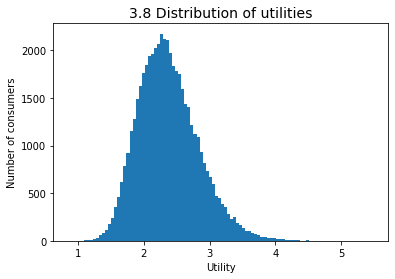

Mean = 2.38 and variance = 0.21


In [65]:
# A. a vector of utilities
utility_vec = utility(p1,p2,e1,e2,e3,betas,gamma)

# B. plotting distribution of utilities
plt.hist(utility_vec, bins=100)

# C. specifying titles, labels etc.
plt.title('3.8 Distribution of utilities', fontsize=14)
plt.xlabel('Utility')
plt.ylabel('Number of consumers')

# D. calculating and printing mean and variance
mean = np.mean(utility_vec)
var = np.var(utility_vec)

# E. showing the graph
plt.show()
print(f'Mean = {mean:.2f} and variance = {var:.2f}')

We see that the distribution of the agents utility in the Walras equilibrium is approximately normal distributed with mean  2.38 and variance 0.21. 

### **Question 5** ###

**The task:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

We find the Walras-equilibrium prices where all endowments is distributed equally. It is chosen to set the endowments equal to the mean of each initial endowments in order to obtain equally distributed endowments. 

In [66]:
# Set new set of endowments, equal to mean of each initial endowment
e1_new = np.zeros(N)+np.mean(e1)
e2_new = np.zeros(N)+np.mean(e2)
e3_new = np.zeros(N)+np.mean(e3)

p1 = 1.5
p2 = 0.5

p1, p2 = find_equilibrium(p1,p2,e1_new,e2_new,e3_new,betas)

Iteration      0: excess demand 1 = 14290.2395, excess demand 2 = 27695.9518 ---> p1 =     1.6429, p2 =     0.7770
Iteration      1: excess demand 1 = 16876.9040, excess demand 2 =  7045.1855 ---> p1 =     1.8117, p2 =     0.8474
Iteration      2: excess demand 1 = 14882.8211, excess demand 2 =  5959.1693 ---> p1 =     1.9605, p2 =     0.9070
Iteration      3: excess demand 1 = 13367.9130, excess demand 2 =  5258.5722 ---> p1 =     2.0942, p2 =     0.9596
Iteration      4: excess demand 1 = 12176.4313, excess demand 2 =  4744.1435 ---> p1 =     2.2159, p2 =     1.0070
   ...
Iteration    500: excess demand 1 =    21.5590, excess demand 2 =     8.0541 ---> p1 =     6.4627, p2 =     2.6085
Iteration   1000: excess demand 1 =     0.2169, excess demand 2 =     0.0810 ---> p1 =     6.4858, p2 =     2.6172
Iteration   1500: excess demand 1 =     0.0022, excess demand 2 =     0.0008 ---> p1 =     6.4860, p2 =     2.6172
Iteration   2000: excess demand 1 =     0.0000, excess demand 2 =     0.0

We find the new Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero to be $p_1 = 6.4860$ and $p_2 = 2.6172$.

We plot both the new and old distribution of utilities and include a widget, so we can see what happens when we change $\gamma$.  

In [67]:
# A. defining the distribution of utility
def plot_utility(gamma):
    
    # i. a vector of utilities
    utility_vec = utility(p1,p2,e1,e2,e3,betas,gamma)
    utility_vec_new = utility(p1,p2,e1_new,e2_new,e3_new,betas,gamma)
    
    # ii. initiate subplot-figure
    fig, (axis1, axis2) = plt.subplots(nrows=1,ncols=2,figsize=(12,5))

    # iii. plot utility distributions and set figure-properties
    axis1.hist(utility_vec_new, bins=100)
    axis1.set_title('3.9 Distribution of utilites with \nequally distributed endowments')
    axis1.set_xlabel('Utility')
    axis1.set_ylabel('Number of consumers')

    axis2.hist(utility_vec, bins=100)
    axis2.set_title('3.10 Distribution of utilities with \nexponential distributed endowments')
    axis2.set_xlabel('Utility')   
        
    # iv. calculating and printing mean and variance
    mean = np.mean(utility_vec)
    var = np.var(utility_vec)
    mean_new = np.mean(utility_vec_new)
    var_new = np.var(utility_vec_new)
    
    # v. print text containing means and variances
    text = f'{" ":13s}'
    text += f'Mean = {mean_new:.3f}, variance = {var_new:.3f}'
    text += f'{" ":21s}'
    text += f'Mean = {mean:.3f}, variance = {var:.3f}'
  
    plt.show()
    print(text)  
    
# B. calling interactive function
widgets.interact(plot_utility,
    gamma=widgets.FloatSlider(description='$\\gamma$', min=0.1, max=2, step=0.05, value=2)
    );

interactive(children=(FloatSlider(value=2.0, description='$\\gamma$', max=2.0, min=0.1, step=0.05), Output()),…

The calculated equilibrium prices and the figures above show that, even though the equilibrium prices do not change much, having equally distributed endowments change the distribution of the utility. With equally distributed endowments the distribution of utility has a low variance compared to the situation with exponentially distributed endowments. However, the means are almost identical implying that the expected utilities are close in both cases.  

Raising $\gamma$ raises both the mean and the variance of both distributions, but have a larger effect on the variance when the endowments are exponentially distributed. This is because a high $\gamma$ magnifies the effect of larger differences in endowments. When endowments are equally distributed, the distribution of utilities has a very low variance from the start, hence an increasing $\gamma$ has a lower impact on the variance compared to the case where the endowments are exponentially distributed.